In [1]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import os
import netCDF4 as nc
# import h5py
from tqdm import tqdm
import zarr

### Plot bounds

In [17]:
lats = np.load('pickle_Maps/LATFIELD.npy')
lons = np.load('pickle_Maps/LONFIELD.npy')
ICE = np.load('pickle_Maps/ICE.npy')
mask = np.load('pickle_Maps/OCEAN_MASK.npy')
X = np.load('pickle_Maps/XDIM.npy')
Y = np.load('pickle_Maps/YDIM.npy')

In [18]:
nm = np.zeros(lats.shape)

for i in range(lats.shape[0]):
    for j in range(lats.shape[1]):
        if lats[i,j] < -60:
            nm[i,j] = 1
nm[nm==0] = np.nan

In [19]:
mask[np.isnan(mask)] = 2
mask[mask!=2] = np.nan
ICE[ICE!=0]=1

In [32]:
region = np.zeros(lats.shape)

for i in range(region.shape[0]):
    for j in range(region.shape[1]):
        if lats[i,j] < -68 and lats[i,j] > -75.5 and lons[i,j] > -135 and lons[i,j] < -99:
            region[i,j] = 1

region[region==0] = np.nan

In [36]:
region[np.isnan(region)] = 0

/var/folders/2n/5cjcyrz92xq2s13y29jhm27w0000gn/T/ipykernel_52110/2836514368.py:3: UserWarning: No contour levels were found within the data range.
  ax.contour(X/1000, Y/1000, ICE, levels=[0,1], colors=['white'])
/var/folders/2n/5cjcyrz92xq2s13y29jhm27w0000gn/T/ipykernel_52110/2836514368.py:4: UserWarning: No contour levels were found within the data range.
  ax.contour(X/1000, Y/1000, region*nm, colors=['red'], levels=[0,1], linewidths=5)


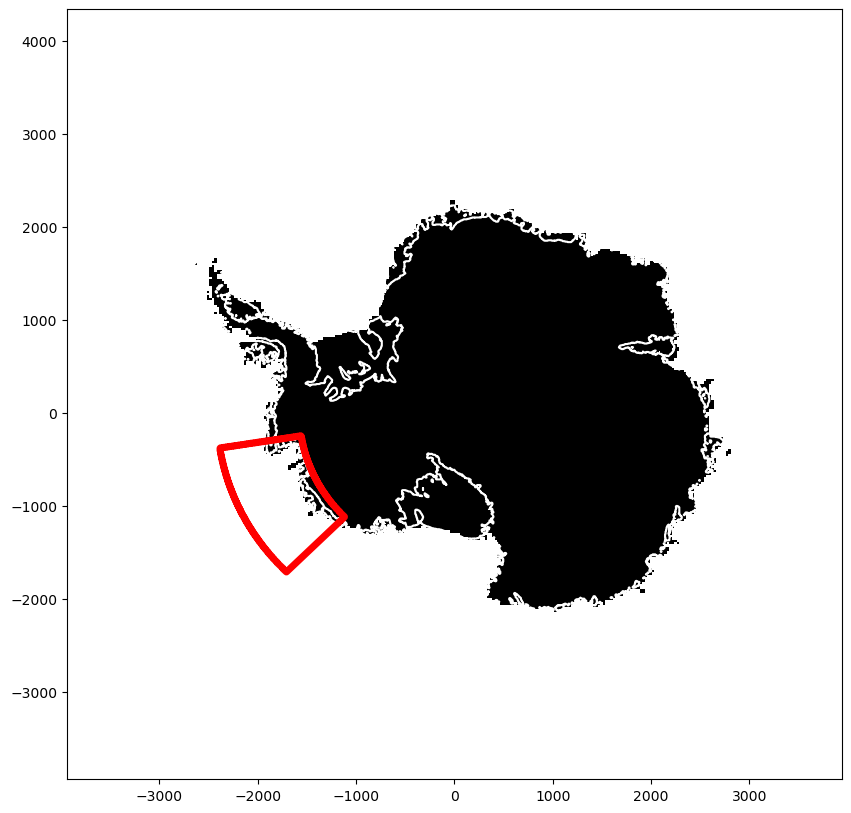

In [44]:
fig, ax = plt.subplots(figsize=(10,10))
ax.pcolormesh(X/1000, Y/1000, mask*nm, cmap='gray')
ax.contour(X/1000, Y/1000, ICE, levels=[0,1], colors=['white'])
ax.contour(X/1000, Y/1000, region*nm, colors=['red'], levels=[0,1], linewidths=5)

plt.savefig('ASE_region.png', dpi=300)

## Get SI Satellite

In [2]:
from pyproj import Transformer
import rasterio as rio

In [3]:
transformer = Transformer.from_crs("EPSG:3412", "EPSG:4326")

In [40]:
path = '/Volumes/workDrive/Sea_Ice/1d_tif'
files = [i for i in os.listdir(path) if 'concentration' in i and 'aux' not in i]
files.sort()
#files = files[8186:8551] ## 2005 - 2006

files = files[10377:10743] ## 2011 - 2012
## remove Feb 29 to allign with other dates
files = files[:151] + files[152:]


files[0], files[-1]

('S_20111001_concentration_v3.0.tif', 'S_20120930_concentration_v3.0.tif')

In [41]:
with rio.open(f"{path}/{files[0]}") as src:
    band1 = src.read(1)
    print('Band1 has shape', band1.shape)
    height = band1.shape[0]
    width = band1.shape[1]
    cols, rows = np.meshgrid(np.arange(width), np.arange(height))
    xs, ys = rio.transform.xy(src.transform, rows, cols)
    # lats = np.array(ys)
    # print('lons shape', lons.shape)

xs = np.asarray(xs)
ys = np.asarray(ys)

Band1 has shape (332, 316)


In [42]:
### Create lat_lon field
latfield = np.zeros((332, 316))
lonfield = np.zeros((332, 316))

for i in range(xs.shape[0]):
    for j in range(xs.shape[1]):
        lat, lon = transformer.transform(xs[i,j], ys[i,j])
        latfield[i,j] = lat
        lonfield[i,j] = lon

In [43]:
mask = np.zeros((332, 316))

for i in range(xs.shape[0]):
    for j in range(xs.shape[1]):
        if latfield[i,j] < -68 and latfield[i,j] > -75.5 and lonfield[i,j] > -135 and lonfield[i,j] < -99:
            mask[i,j] = 1

mask[mask==0] = np.nan

In [44]:
ocean_mask = band1.copy()
ocean_mask = ocean_mask.astype(float)
ocean_mask[ocean_mask >1000] = np.nan
ocean_mask[~np.isnan(ocean_mask)] = 1

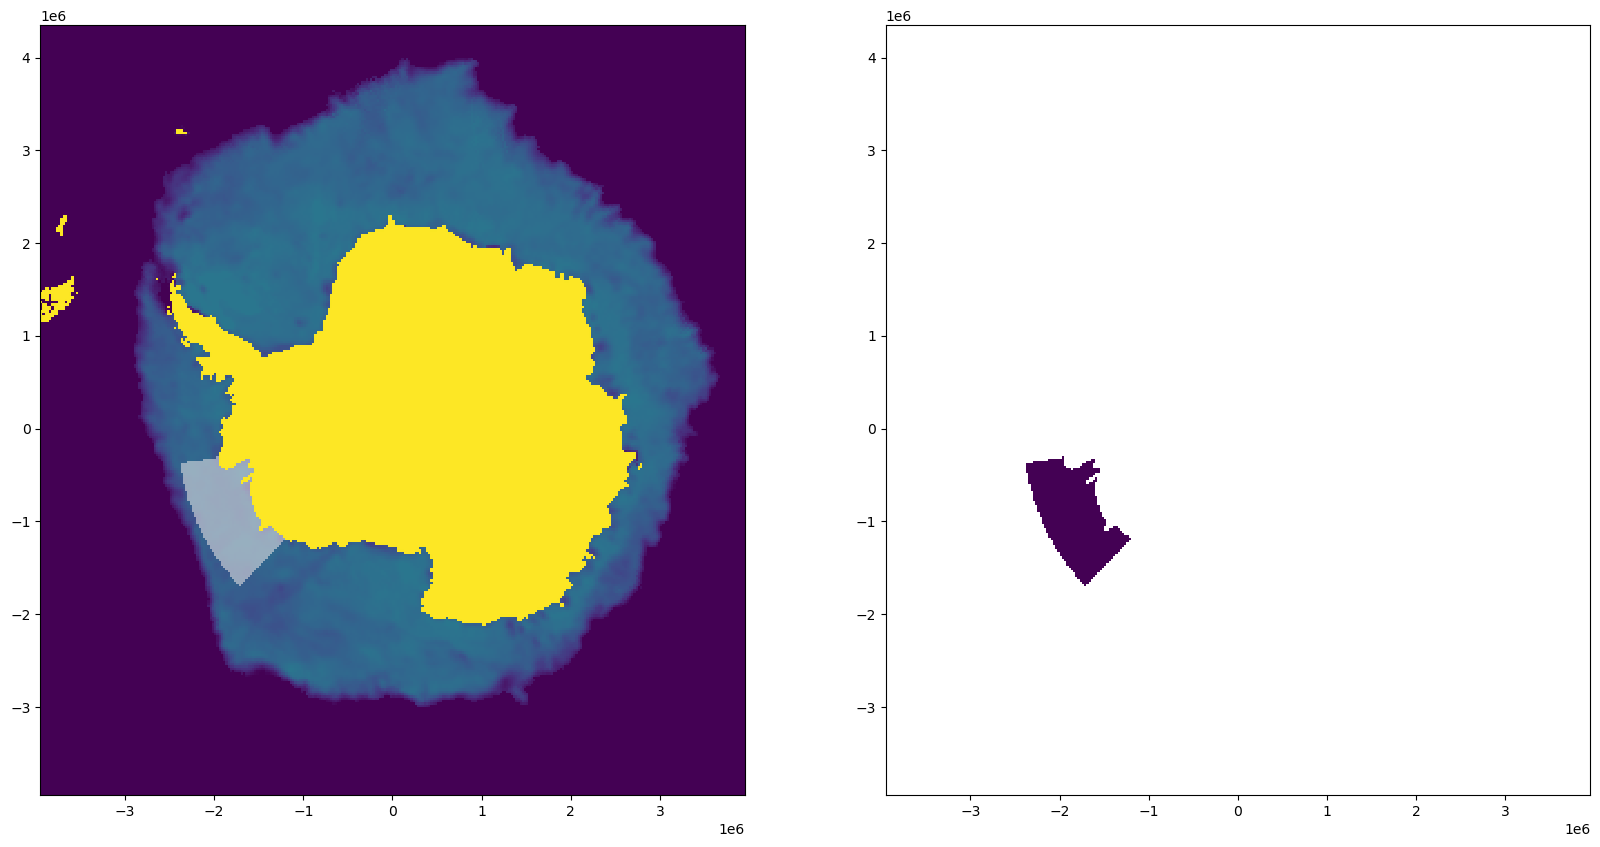

In [45]:
fig, ax = plt.subplots(figsize=(20,10), ncols=2)
ax[0].pcolormesh(xs, ys, band1)
ax[0].pcolormesh(xs, ys, ocean_mask * mask, alpha=0.5, cmap='Reds')
ax[1].pcolormesh(xs, ys, ocean_mask * mask)

In [46]:
### Area mask 
RAC = np.zeros((332, 316))
RAC[:] = 25_000 * 25_000 ### 25km x 25km -> meters

In [47]:
total_area = np.nansum(RAC * ocean_mask * mask)
print(total_area)

849375000000.0


In [48]:
OBS = []
for i in tqdm(range(len(files))):
    temp = rio.open(f"{path}/{files[i]}")
    temp = temp.read(1)
    temp = temp.astype(float)
    temp[temp>1000] = np.nan
    temp = temp / 1000 * RAC * ocean_mask * mask ## ice data range = 1 - 1000

    OBS.append(np.nansum(temp)/total_area)

100%|█████████████████████████████████████████| 365/365 [00:05<00:00, 63.93it/s]


In [50]:
np.save('pickle_ASE/OBS_2011.npy', OBS)

## Get SI Nakayama

In [8]:
path = '/Volumes/backUpDrive/Models/Nakayama_2018/results/A_SI'

In [9]:
files = [i for i in os.listdir(path) if 'SIarea' in i]
files.sort()

In [10]:
XC = loadmat(f"{path}/XC.mat")
XC = XC['XC'][:]
YC = loadmat(f"{path}/YC.mat")
YC = YC['YC'][:]
RAC = loadmat(f"{path}/RAC.mat")
RAC = RAC['RAC'][:]

In [11]:
data = loadmat(f"{path}/{files[0]}")
mask = np.zeros(data['SI'].shape)
print(mask.shape)

(416, 896)


In [12]:
## make ocean mask 
om = nc.Dataset('/Volumes/workDrive/Models/Nakayama_2018/Yoshi.nc')
om = om['THETA'][50,0,:,:]

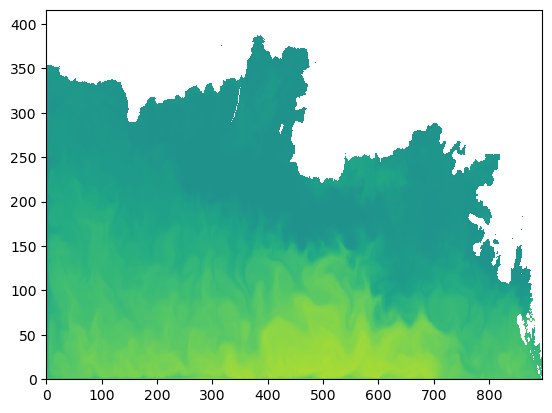

In [14]:
plt.pcolormesh(om)

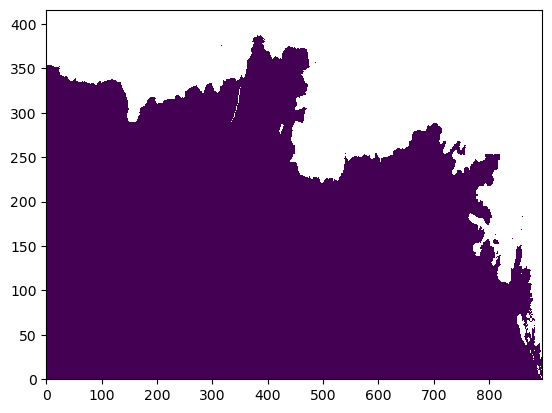

In [15]:
ocean_mask = np.zeros(om.shape)

for i in range(ocean_mask.shape[0]):
    for j in range(ocean_mask.shape[1]):
        if np.isnan(om[i,j]):
            continue
        else:
            ocean_mask[i,j] = 1

ocean_mask[ocean_mask ==0] = np.nan
plt.pcolormesh(ocean_mask)

/var/folders/2n/5cjcyrz92xq2s13y29jhm27w0000gn/T/ipykernel_7894/273071060.py:2: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax.pcolormesh(XC, YC, data['SI'])


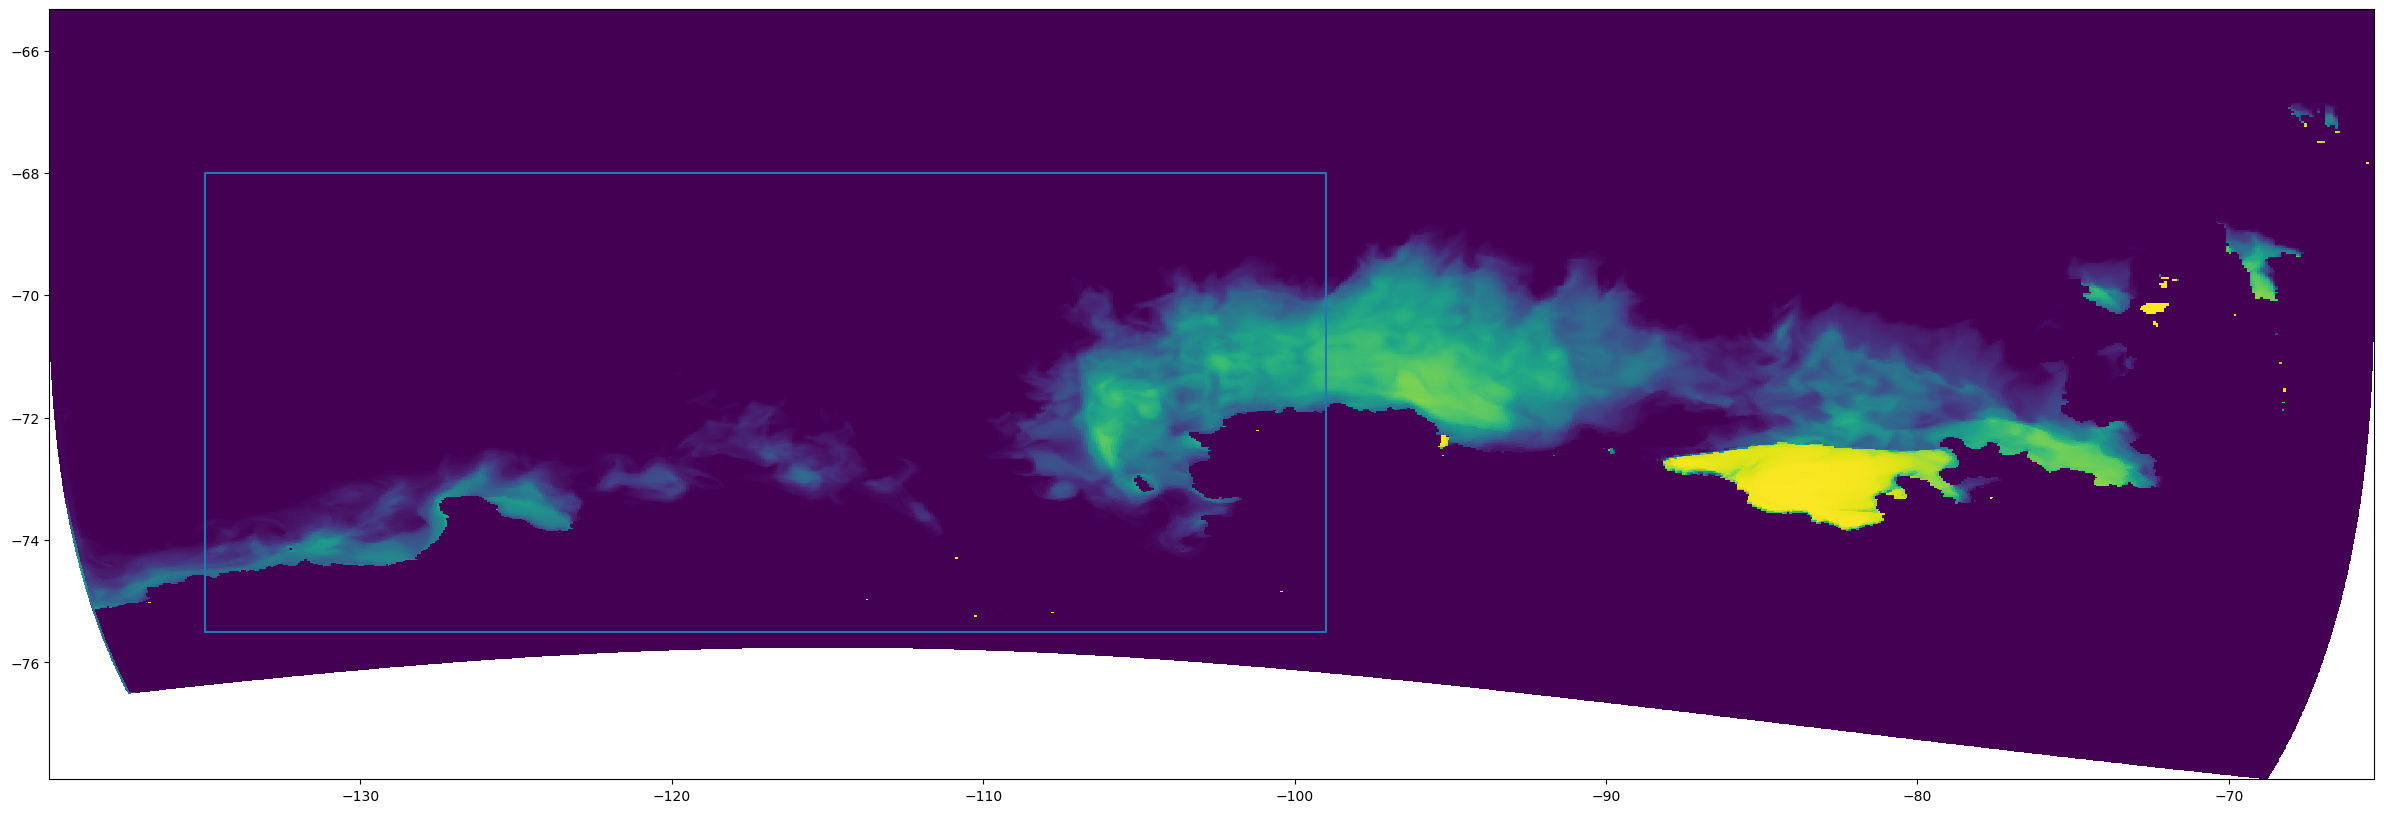

In [16]:
fig, ax = plt.subplots(figsize=(30, 10))
ax.pcolormesh(XC, YC, data['SI'])
ax.plot([-135, -99, -99, -135, -135],
        [-75.5, -75.5, -68, -68, -75.5])

/var/folders/2n/5cjcyrz92xq2s13y29jhm27w0000gn/T/ipykernel_7894/3682906538.py:11: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax.pcolormesh(XC, YC, data['SI'] * ocean_mask)
/var/folders/2n/5cjcyrz92xq2s13y29jhm27w0000gn/T/ipykernel_7894/3682906538.py:12: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax.pcolormesh(XC, YC, region_mask, alpha = 0.4)


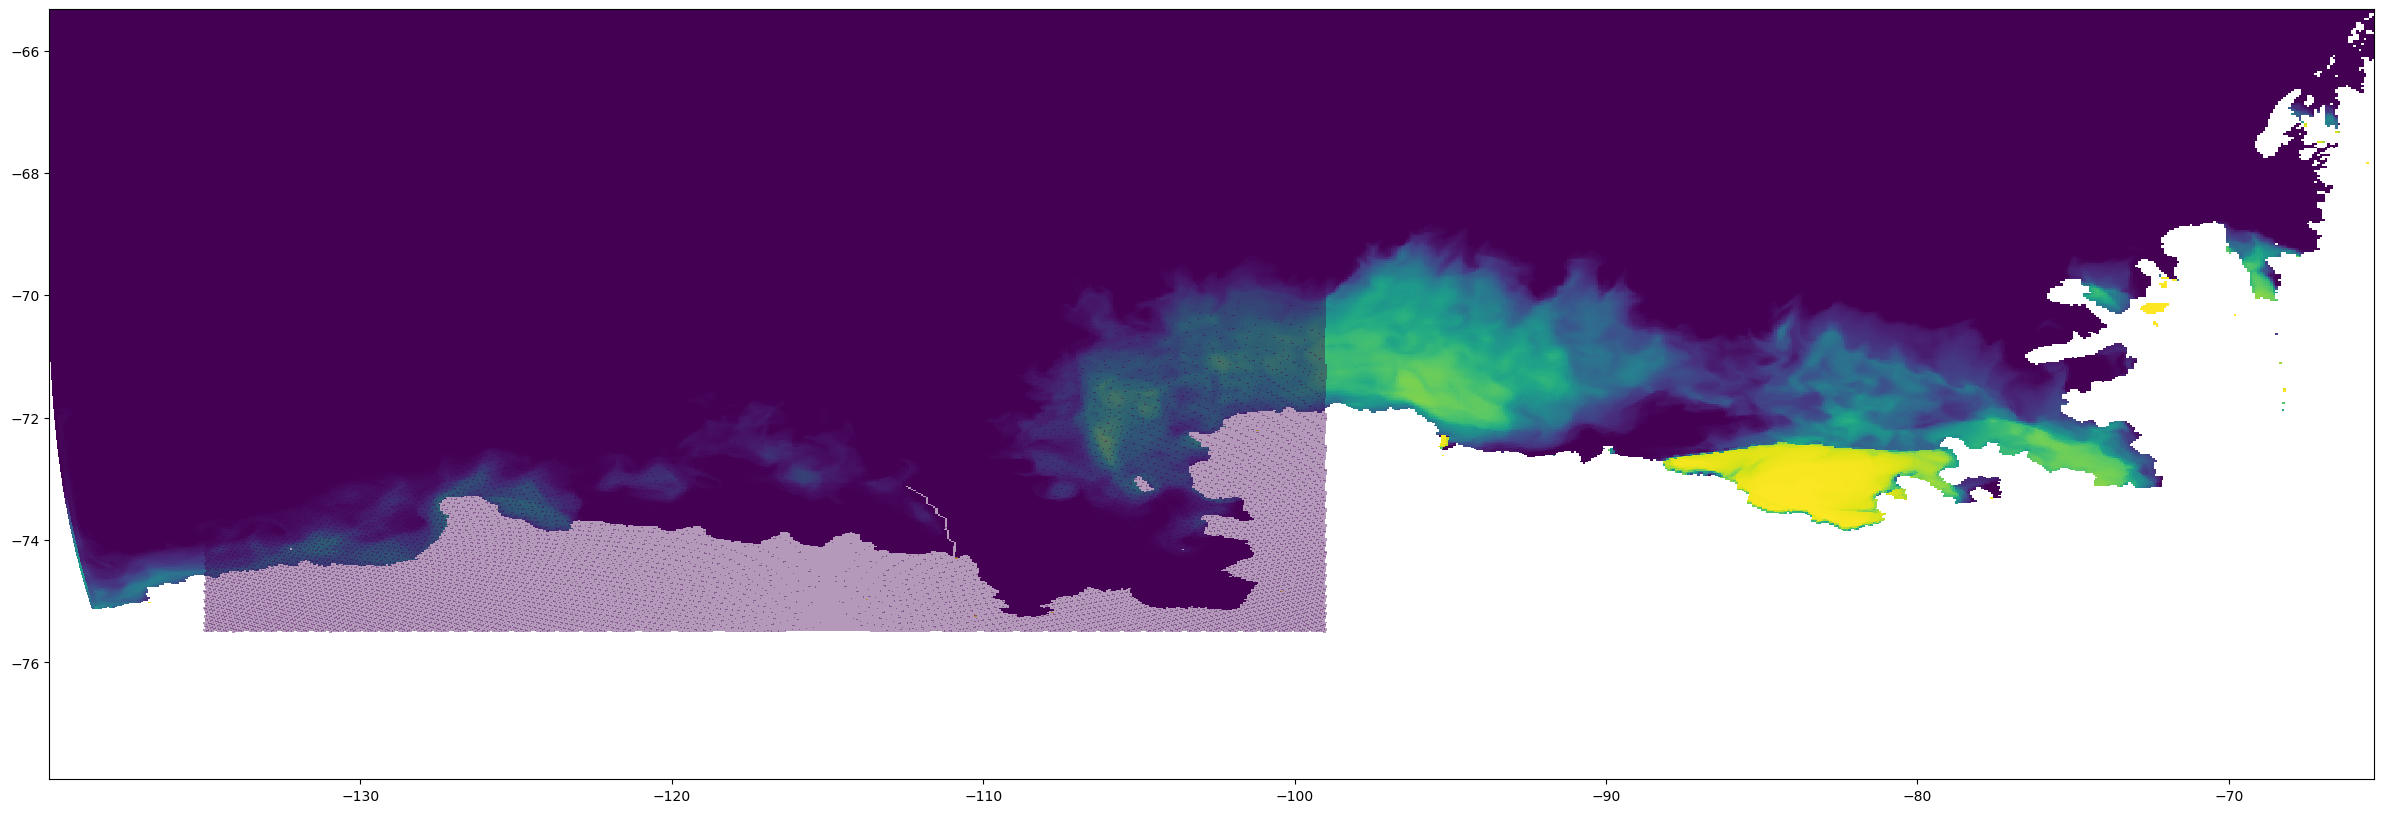

In [17]:
## Create Region Mask
region_mask = np.zeros(XC.shape)

for i in range(XC.shape[0]):
    for j in range(XC.shape[1]):
        if XC[i,j] > -135 and XC[i,j] < -99 and YC[i,j] > -75.5 and YC[i,j] < -68:
            region_mask[i,j] = 1
region_mask[region_mask==0] = np.nan

fig, ax = plt.subplots(figsize=(30, 10))
ax.pcolormesh(XC, YC, data['SI'] * ocean_mask)
ax.pcolormesh(XC, YC, region_mask, alpha = 0.4)

In [33]:
total_area = np.nansum(RAC * region_mask * ocean_mask)
print(total_area)

870131522841.0


In [34]:
YOSHI= []
for i in range(57, 69): ## Oct 2005 to Sep 2006
    data = loadmat(f"{path}/{files[i]}")
    data = data['SI'][:] * ocean_mask * region_mask * RAC
    YOSHI.append(np.nansum(data)/total_area)

In [35]:
np.save('pickle/YOSHI.npy', YOSHI)

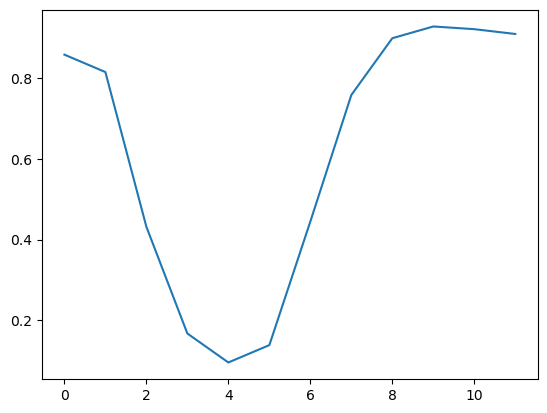

In [36]:
plt.plot(YOSHI)

## Get ECCO4

In [3]:
cube = nc.Dataset('/Volumes/workDrive/SIO_Backup/Data/Models/ECCO/LLC90_v4r4.nc')
XC = cube['lon'][:]
YC = cube['lat'][:]

DXG = cube['DXG'][:]
DYG = cube['DYG'][:]
Area = DXG * DYG

In [4]:
### Create regional_mask
area_mask = np.zeros(Area.shape)

for i in range(XC.shape[0]):
    for j in range(XC.shape[1]):
        lat = YC[i,j]
        lon = XC[i,j]
        if lat > -75.5 and lat < -68 and lon > -135 and lon <-99:
            area_mask[i,j] = 1
            
area_mask[area_mask==0] = np.nan

In [5]:
### make land mask 
lm = cube['THETA'][0,0,:,:]
lm[~np.isnan(lm)] = 1

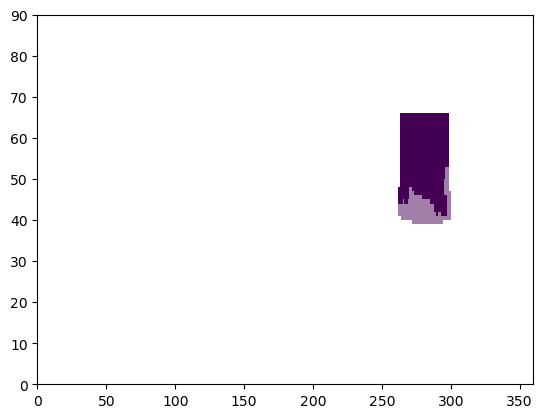

In [6]:
plt.pcolormesh(lm * area_mask)
plt.pcolormesh(area_mask,alpha=0.5)

In [8]:
cube = nc.Dataset('/Volumes/workDrive/Models/ECCO/ECCO4_SIarea_Daily.nc')
SI = cube['SIarea']

In [9]:
total_area = np.nansum(Area * lm * area_mask)
print(total_area)

851569907456.0


In [15]:
ECCO = []
for t in cube['SIarea'][274:274+365]:
    SI = np.nansum(t * lm * Area * area_mask)/total_area
    ECCO.append(SI)

In [17]:
np.save('pickle_ASE/ECCO.npy', np.asarray(ECCO))

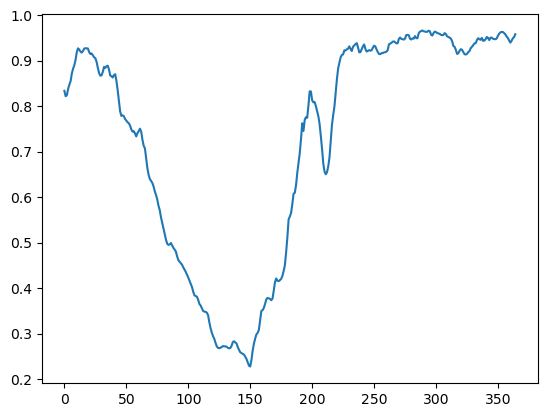

In [16]:
plt.plot(ECCO)

## Get SOhi

In [2]:
import h5py

In [3]:
path = '/Volumes/workDrive/SIO_Backup/Data/Models/SOHI/2D'
files = [i for i in os.listdir(path) if '.nc' in i]
files.sort()
files.pop(0)

'2D_2005_09C.nc'

In [4]:
RAC = h5py.File('/Volumes/workDrive/SIO_Backup/Data/Models/SOHI/meta/GRID_v8.mat')

In [5]:
XC = RAC['XC'][0,:]
YC = RAC['YC'][:,0]
RAC = RAC['DXG'][:] * RAC['DYG'][:]

In [6]:
x1 = np.argmin(abs(-135%360 - XC))
x2 = np.argmin(abs(-99%360 - XC))
y2 = np.argmin(abs(-68 - YC))
y1 = np.argmin(abs(-75.5 - YC))

In [7]:
RAC = RAC[y1:y2, x1:x2]

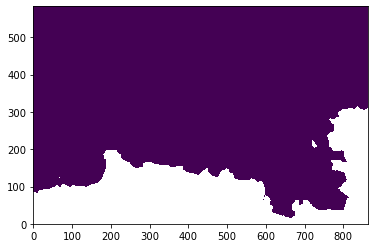

In [16]:
ocean_mask = nc.Dataset('/Volumes/workDrive/SIO_Backup/Data/Models/SOHI/Monthly_Mean/2005_09.nc')
ocean_mask = ocean_mask['THETA'][0,0,:,:]
ocean_mask[~np.isnan(ocean_mask)] = 1
ocean_mask = ocean_mask[y1:y2, x1:x2]
plt.pcolormesh(ocean_mask)

In [17]:
total_area = np.nansum(RAC*ocean_mask)
print(total_area)

872907740000.0


In [23]:
SOhi = []
for p in files:
    data = nc.Dataset(f"{path}/{p}")
    data = data['SIarea']
    for t in tqdm(range(0,data.shape[0],4)):
        temp = data[t:t+4,y1:y2, x1:x2].mean(axis=0)
        SOhi.append(np.nansum(temp * RAC * ocean_mask)/total_area)

100%|█████████████████████████████| 30/30 [00:06<00:00,  4.53it/s]


In [24]:
np.save('pickle/SOhi.npy', np.asarray(SOhi))

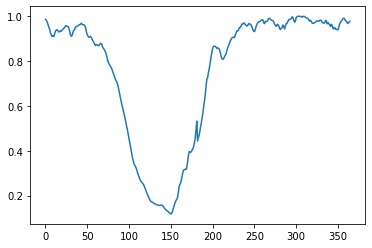

In [25]:
plt.plot(SOhi)

## Get SI SOSE

In [44]:
path = '/Volumes/workDrive/Models/SOSE/SI/SI_mat'
files = [i for i in os.listdir(path) if '.mat' in i]
files.sort()
files.pop()
files

['274.mat',
 '275.mat',
 '276.mat',
 '277.mat',
 '278.mat',
 '279.mat',
 '280.mat',
 '281.mat',
 '282.mat',
 '283.mat',
 '284.mat',
 '285.mat',
 '286.mat',
 '287.mat',
 '288.mat',
 '289.mat',
 '290.mat',
 '291.mat',
 '292.mat',
 '293.mat',
 '294.mat',
 '295.mat',
 '296.mat',
 '297.mat',
 '298.mat',
 '299.mat',
 '300.mat',
 '301.mat',
 '302.mat',
 '303.mat',
 '304.mat',
 '305.mat',
 '306.mat',
 '307.mat',
 '308.mat',
 '309.mat',
 '310.mat',
 '311.mat',
 '312.mat',
 '313.mat',
 '314.mat',
 '315.mat',
 '316.mat',
 '317.mat',
 '318.mat',
 '319.mat',
 '320.mat',
 '321.mat',
 '322.mat',
 '323.mat',
 '324.mat',
 '325.mat',
 '326.mat',
 '327.mat',
 '328.mat',
 '329.mat',
 '330.mat',
 '331.mat',
 '332.mat',
 '333.mat',
 '334.mat',
 '335.mat',
 '336.mat',
 '337.mat',
 '338.mat',
 '339.mat',
 '340.mat',
 '341.mat',
 '342.mat',
 '343.mat',
 '344.mat',
 '345.mat',
 '346.mat',
 '347.mat',
 '348.mat',
 '349.mat',
 '350.mat',
 '351.mat',
 '352.mat',
 '353.mat',
 '354.mat',
 '355.mat',
 '356.mat',
 '35

In [46]:
grid = loadmat('/Volumes/workDrive/Models/SOSE/meta/grid.mat')

In [56]:
XC = grid['XC'][:,0]
YC = grid['YC'][0,:]

In [59]:
x1 = np.argmin(abs(-135%360 - XC))
x2 = np.argmin(abs(-99%360 - XC))
y2 = np.argmin(abs(-68 - YC))
y1 = np.argmin(abs(-75.5 - YC))

In [82]:
RAC = np.swapaxes(grid['RAC'][:], 0,1) 
RAC = RAC[y1:y2, x1:x2]

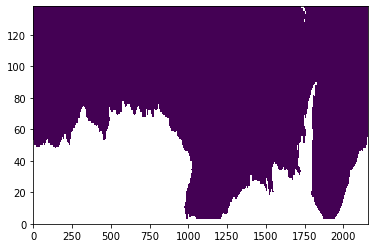

In [68]:
## create landmask 
cube = nc.Dataset('/Volumes/workDrive/SIO_Backup/Data/Models/SOSE/SOSE_iter100.nc')
mask = cube['THETA'][0,0,:,:]
mask[~np.isnan(mask)] = 1
plt.pcolormesh(mask)

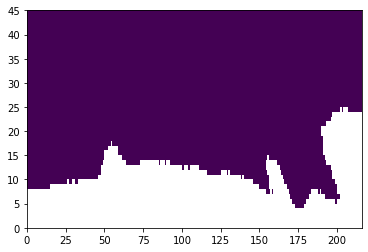

In [69]:
mask = mask[y1:y2, x1:x2]
plt.pcolormesh(mask)

In [85]:
total_area = np.nansum(RAC * mask)
print(total_area)

796872462864.0


In [86]:
SOSE = []

for f in files:
    temp = loadmat(f"{path}/{f}")
    temp = np.swapaxes(temp['SI'][:], 0, 1)
    temp = temp[y1:y2, x1:x2]
    SOSE.append(np.nansum(temp*RAC*mask)/total_area)

In [87]:
np.save('pickle/SOSE.npy', np.asarray(SOSE))

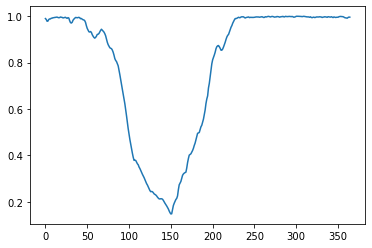

In [88]:
plt.plot(SOSE)

## Get LLC4320

In [93]:
data = zarr.open('/Volumes/workDrive/Models/LLC4320/SI.zarr', 'r')

In [167]:
list(data.keys())

['DRF', 'DXG', 'DYG', 'SIarea', 'depth', 'lat', 'lon']

In [134]:
XC = np.load('/Volumes/workDrive/SIO_Backup/Data/Models/LLC4320/meta/XC.npy')
YC = np.load('/Volumes/workDrive/SIO_Backup/Data/Models/LLC4320/meta/YC.npy')

In [135]:
XC = XC[1500:3500, 12000:15000]
YC = YC[1500:3500, 12000:15000]

In [139]:
DXG = np.load('/Volumes/workDrive/SIO_Backup/Data/Models/LLC4320/meta/dxg.npy')
DXG = DXG[1500:3500, 12000:15000]

DYG = np.load('/Volumes/workDrive/SIO_Backup/Data/Models/LLC4320/meta/dyg.npy')
DYG = DYG[1500:3500, 12000:15000]

Area = DXG * DYG

/var/folders/2n/5cjcyrz92xq2s13y29jhm27w0000gn/T/ipykernel_19754/305145399.py:2: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax.pcolormesh(XC, YC, Area)


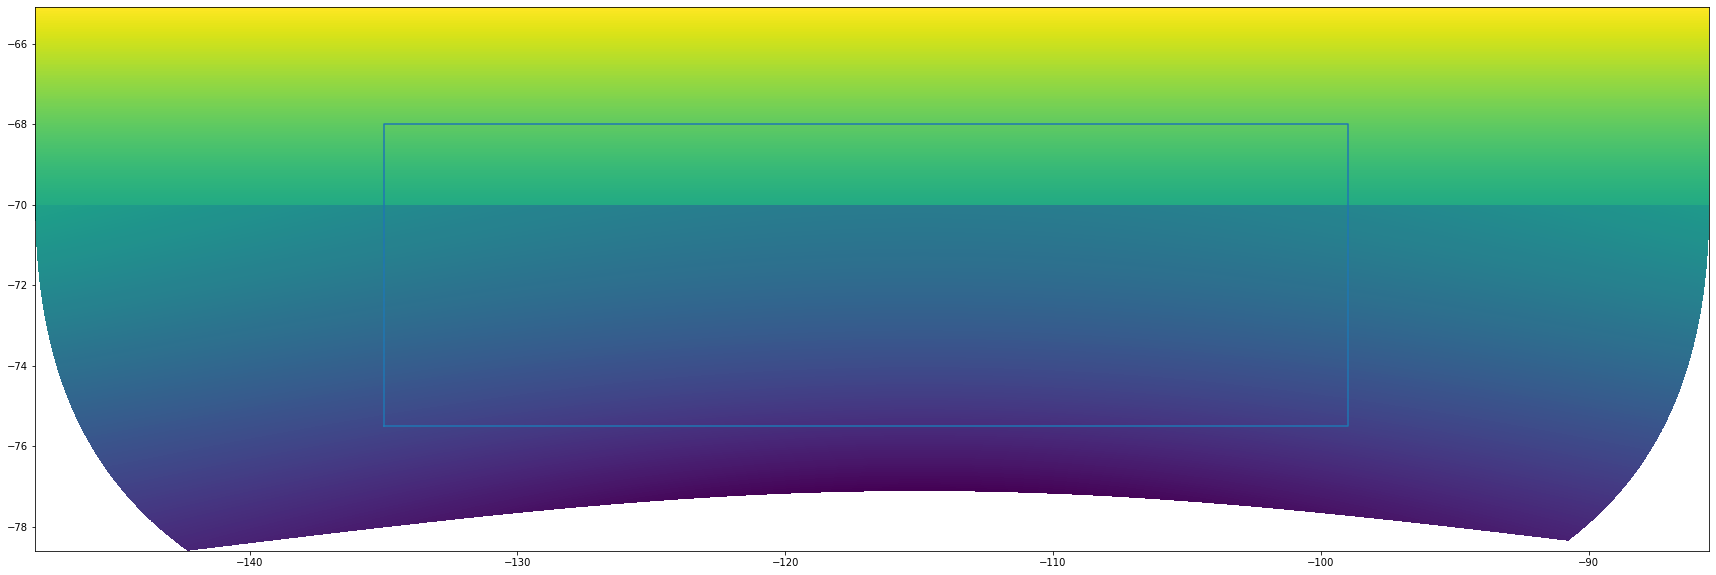

In [140]:
fig, ax = plt.subplots(figsize=(30,10))
ax.pcolormesh(XC, YC, Area)
ax.plot([-135, -99, -99, -135, -135],
       [-75.5, -75.5, -68, -68, -75.5])

In [ ]:
### Create regional_mask
area_mask = np.zeros(Area.shape)

for i in range(XC.shape[0]):
    for j in range(XC.shape[1]):
        lat = YC[i,j]
        lon = XC[i,j]
        if lat > -75.5 and lat < -68 and lon > -135 and lon <-99:
            area_mask[i,j] = 1
            
area_mask[area_mask==0] = np.nan

In [160]:
### make land mask 
cube = nc.Dataset('/Volumes/workDrive/SIO_Backup/Data/Models/LLC4320/Monthly_Mean/2011_10.nc')
lm = cube['Theta'][0,1500:3500, 12000:15000]
lm[~np.isnan(lm)] = 1

/var/folders/2n/5cjcyrz92xq2s13y29jhm27w0000gn/T/ipykernel_19754/2682667316.py:2: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax[0].pcolormesh(XC, YC, lm)
/var/folders/2n/5cjcyrz92xq2s13y29jhm27w0000gn/T/ipykernel_19754/2682667316.py:3: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax[0].pcolormesh(XC, YC, area_mask, alpha=0.5)
/var/folders/2n/5cjcyrz92xq2s13y29jhm27w0000gn/T/ipykernel_19754/2682667316.py:5: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated 

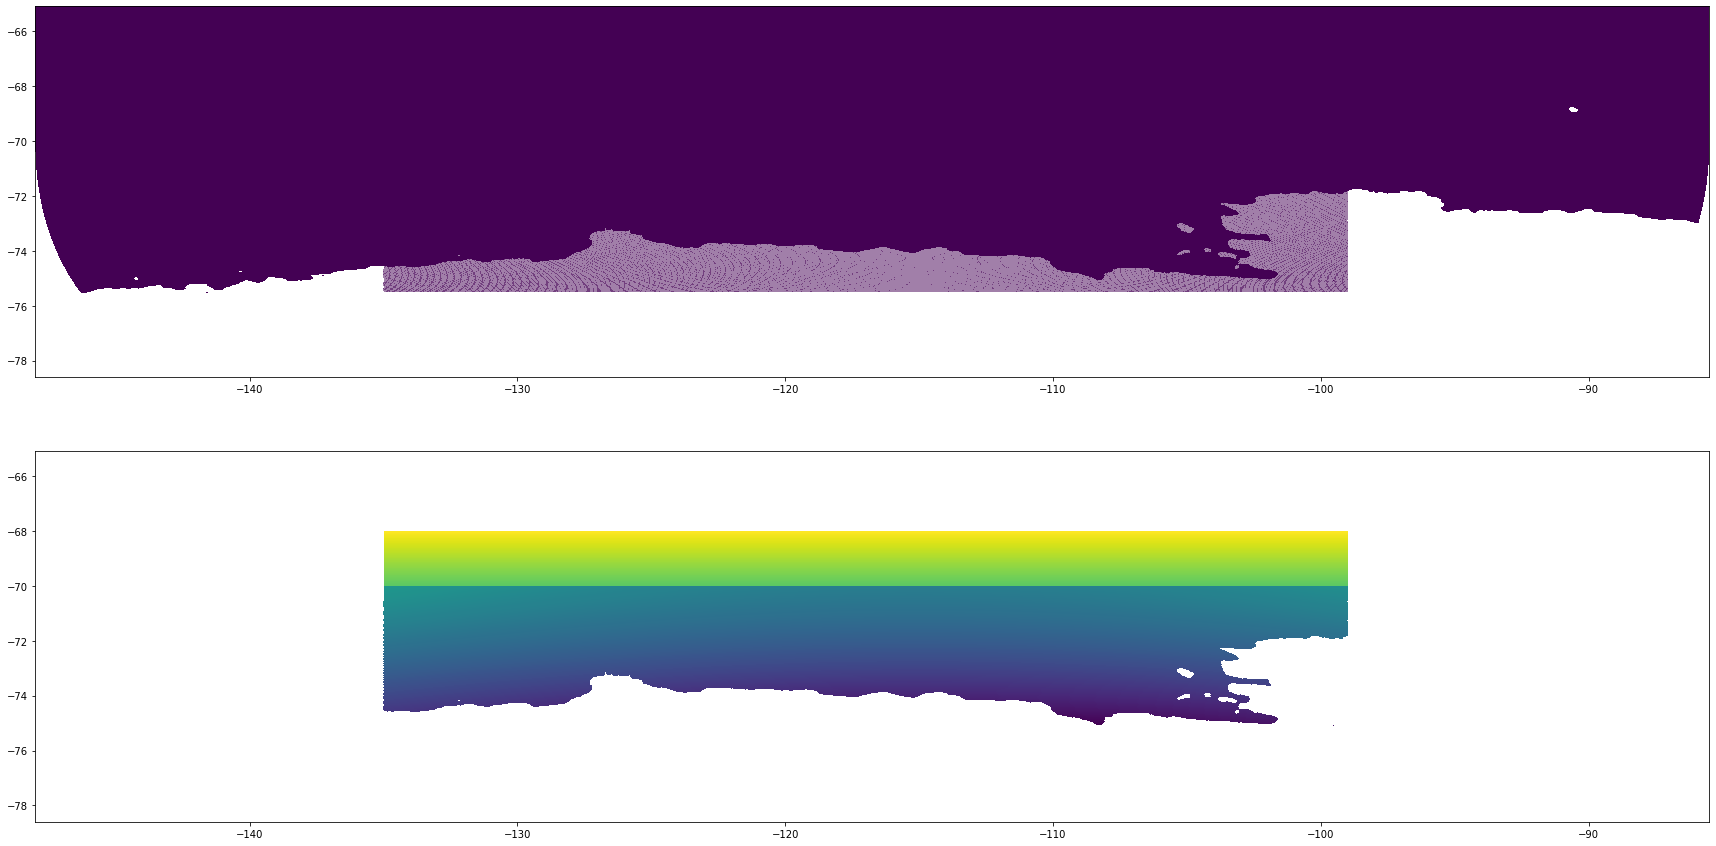

In [164]:
fig, ax = plt.subplots(figsize=(30,15), nrows=2)
ax[0].pcolormesh(XC, YC, lm)
ax[0].pcolormesh(XC, YC, area_mask, alpha=0.5)

ax[1].pcolormesh(XC, YC, Area*area_mask*lm)


In [171]:
total_area = np.nansum(Area * lm * area_mask)
print(total_area)

858195016621.1562


In [175]:
LLC4320 = []
for t in range(365):
    SI = data['SIarea'][t, 1500:3500, 12000:15000]
    SI = np.nansum(SI * lm * area_mask * Area)/total_area
    LLC4320.append(SI)

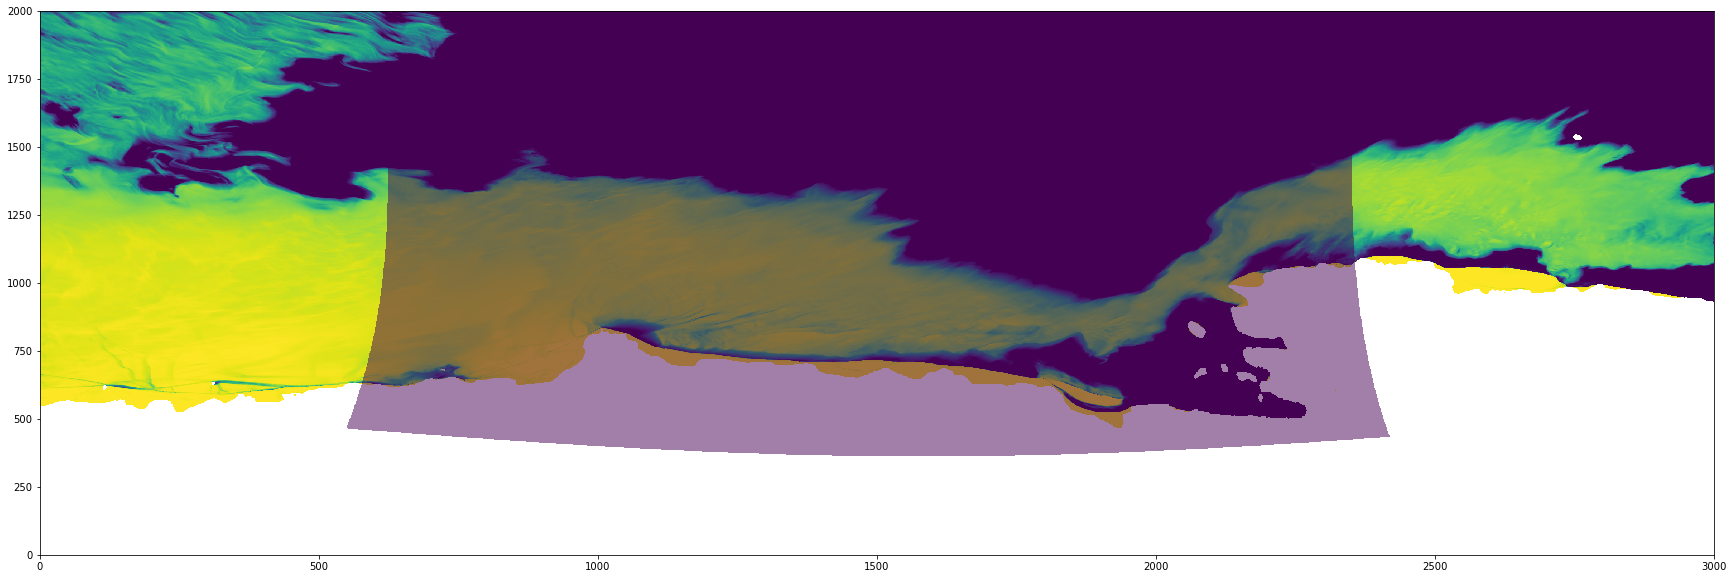

In [189]:
fig, ax = plt.subplots(figsize=(30,10))
ax.pcolormesh(data['SIarea'][120, 1500:3500, 12000:15000] * lm)
ax.pcolormesh(area_mask, alpha=0.5)

In [176]:
np.save('pickle/LLC4320.npy', np.asarray(LLC4320))

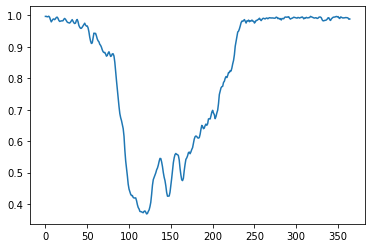

In [177]:
plt.plot(LLC4320)

## Plot

In [51]:
YOSHI = np.load('pickle_ASE/YOSHI.npy')
SOhi = np.load('pickle_ASE/SOhi.npy')
SOSE = np.load('pickle_ASE/SOSE.npy')
OBS = np.load('pickle_ASE/OBS.npy')
OBS2011 = np.load('pickle_ASE/OBS_2011.npy')
LLC4320 = np.load('pickle_ASE/LLC4320.npy')
ECCO = np.load('pickle_ASE/ECCO.npy')

### Total Area 
849375000000 ## Satellite

858195016621 ## LLC4320

872907740000 ## SOhi

796872462864 ## SOSE

870131522841 ## Nakayama


In [52]:

ndays = np.cumsum(np.asarray([15, 31, 30, 31, 31, 28, 31, 30, 31, 30, 31, 31]))


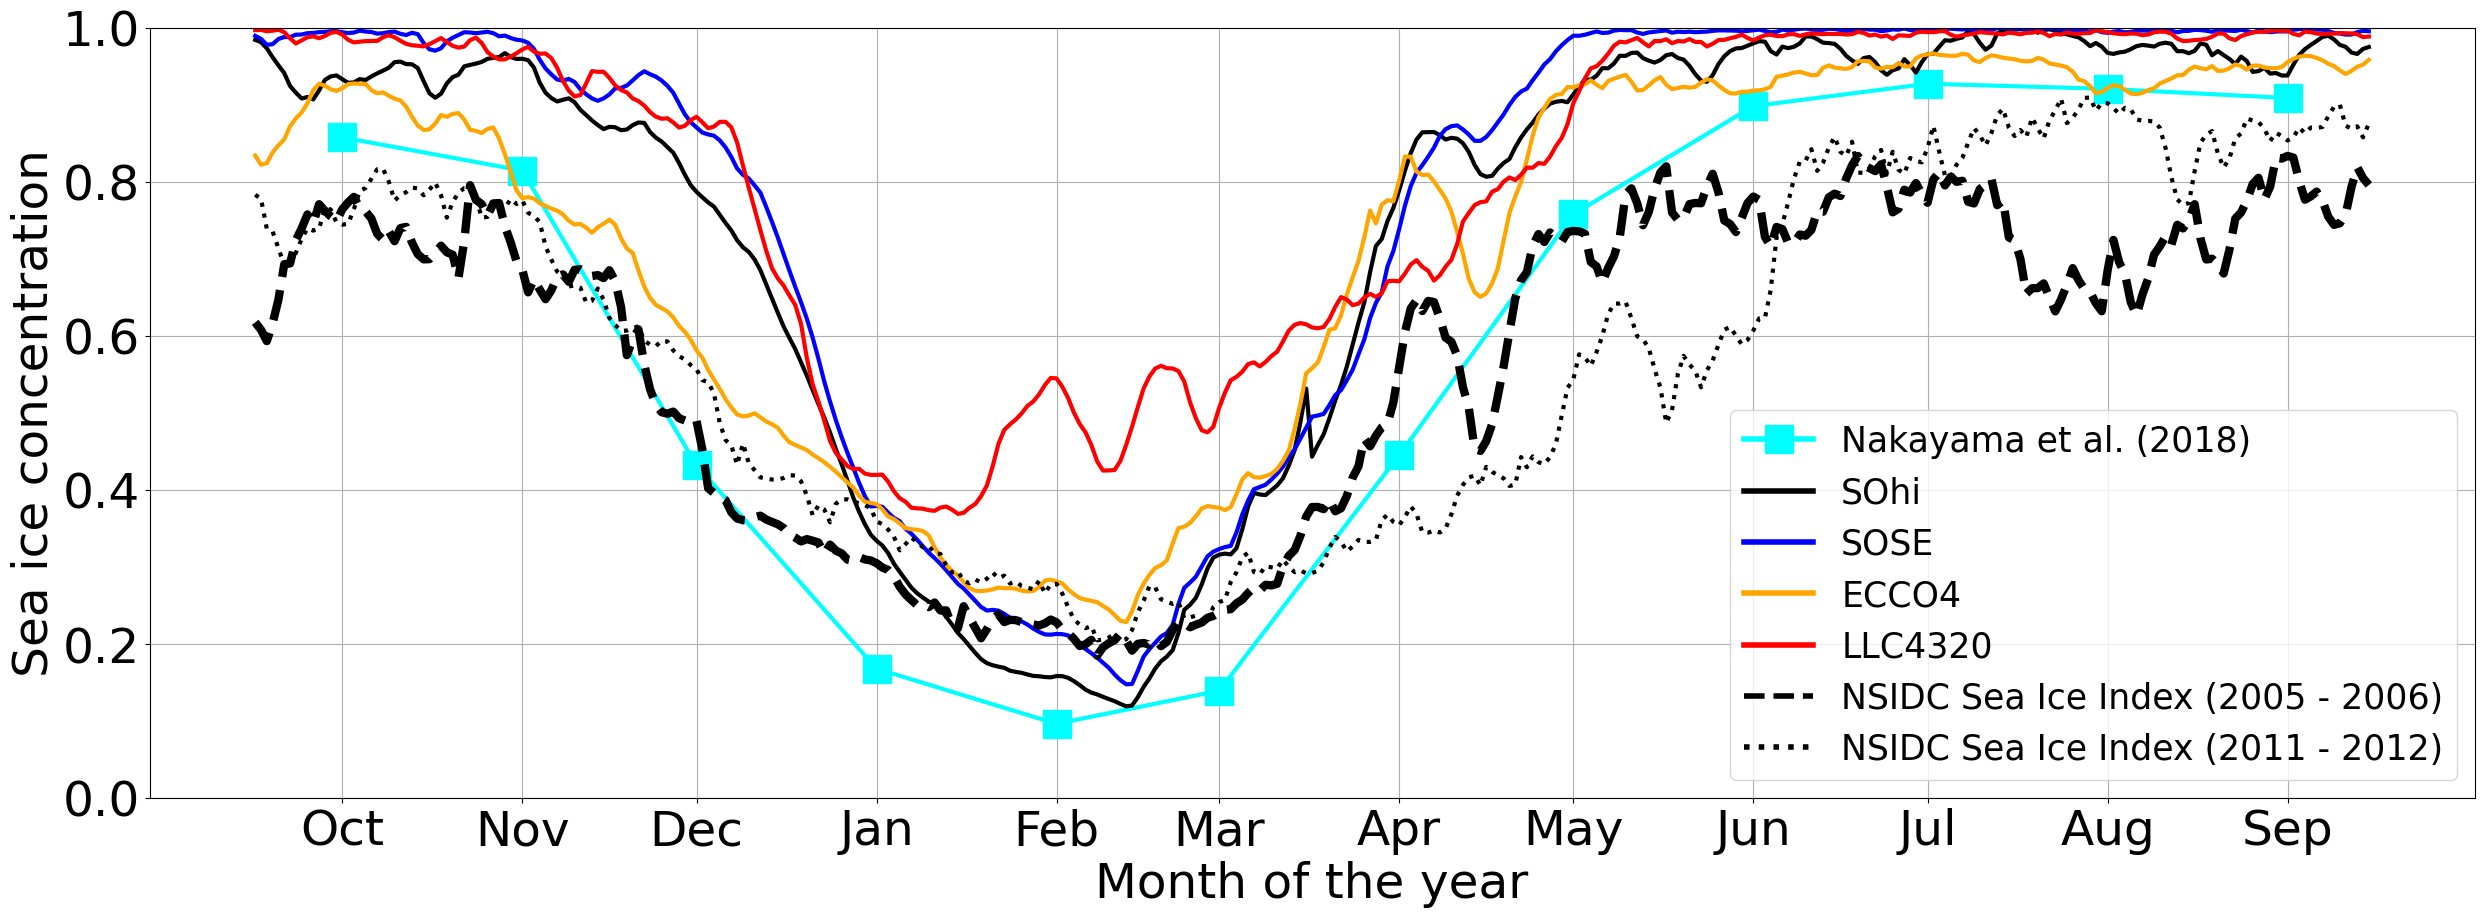

In [64]:
fig, ax = plt.subplots(figsize=(30,10))
ax.plot(ndays, YOSHI, '-s',color='cyan',  label='Nakayama et al. (2018)', lw=3, ms=20)
ax.plot(np.arange(365),SOhi, color='k', label='SOhi', lw=3)
ax.plot(np.arange(365),SOSE, color='blue', label='SOSE', lw=3)
ax.plot(np.arange(365),ECCO, color='orange', label='ECCO4', lw=3)
ax.plot(np.arange(365),LLC4320, color='red', label='LLC4320', lw=3)
ax.plot(np.arange(365),OBS,'--', color='k', lw=6, label='NSIDC Sea Ice Index (2005 - 2006)')
ax.plot(np.arange(365),OBS2011,':', color='k', lw=3, label='NSIDC Sea Ice Index (2011 - 2012)')

ax.set_ylabel('Sea ice concentration', fontsize=35)
ax.set_xlabel('Month of the year', fontsize=35)
ax.tick_params(axis='both', labelsize=35)

legend = ax.legend(fontsize=25)
for line in legend.get_lines():
    line.set_linewidth(4)
    
ax.set_xticks(ndays)
ax.set_xticklabels(['Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep'])

ax.grid()
ax.set_ylim(0,1)

plt.savefig('Sea_Ice_Concentration.jpg', dpi=300)